In [31]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import numpy as np

import keras

In [2]:
import bayesflow as bf
from dmc import DMC

2025-04-01 17:30:56.828371: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 17:30:56.828677: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 17:30:56.830548: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 17:30:56.853208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 17:30:57.242682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

## Create Simulator

In [3]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500,
)

In [16]:
sims = simulator.sample(10)
for k, v in sims.items():
    print(f"Shape of {k}: {v.shape}")

Shape of A: (10, 1)
Shape of tau: (10, 1)
Shape of mu_c: (10, 1)
Shape of t0: (10, 1)
Shape of b: (10, 1)
Shape of rt: (10, 200, 1)
Shape of accuracy: (10, 200, 1)
Shape of conditions: (10, 200, 1)
Shape of num_obs: (10, 1)


## Create Adapter

In [15]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "t0", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)
     

In [10]:
for k, v in adapter(sims).items():
    print(f"Shape of {k}: {v.shape}")

Shape of inference_variables: (10, 5)
Shape of summary_variables: (10, 200, 3)
Shape of inference_conditions: (10, 1)


## Create Networks and Workflow

In [27]:
inference_net = bf.networks.CouplingFlow()
summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=4)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='checkpoints/test',
    checkpoint_name= "simons_crazy_net",
    inference_variables=["A", "tau", "mu_c", "t0", "b"]
)

## Generate Data and Train Offline

In [26]:
train_data = simulator.sample(3000)
val_data = simulator.sample(100)

In [28]:
%%time
history = workflow.fit_offline(train_data, epochs=50, batch_size=16, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 7.0067 - loss/inference_loss: 7.0067 - val_loss: 6.2736 - val_loss/inference_loss: 6.2736
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 6.0124 - loss/inference_loss: 6.0124 - val_loss: 3.4097 - val_loss/inference_loss: 3.4097
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 5.3105 - loss/inference_loss: 5.3105 - val_loss: 5.2703 - val_loss/inference_loss: 5.2703
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 4.6959 - loss/inference_loss: 4.6959 - val_loss: 3.2609 - val_loss/inference_loss: 3.2609
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 4.3325 - loss/inference_loss: 4.3325 - val_loss: 4.1867 - val_loss/inference_loss: 4.1867
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 3.8262 - loss/inference_loss: 3.8262 - val_loss: 2.8757 - val_loss/inference_loss: 2.8757
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 3.5940 - loss/inference_loss: 3.

INFO:bayesflow:Training is now finished.
            You can find the trained approximator at 'checkpoints/test/simons_crazy_net.simons_crazy_net.keras'.
            To load it, use approximator = keras.saving.load_model(...).


CPU times: user 1h 18min 24s, sys: 3min 16s, total: 1h 21min 40s
Wall time: 7min 15s


## In Silico Validation

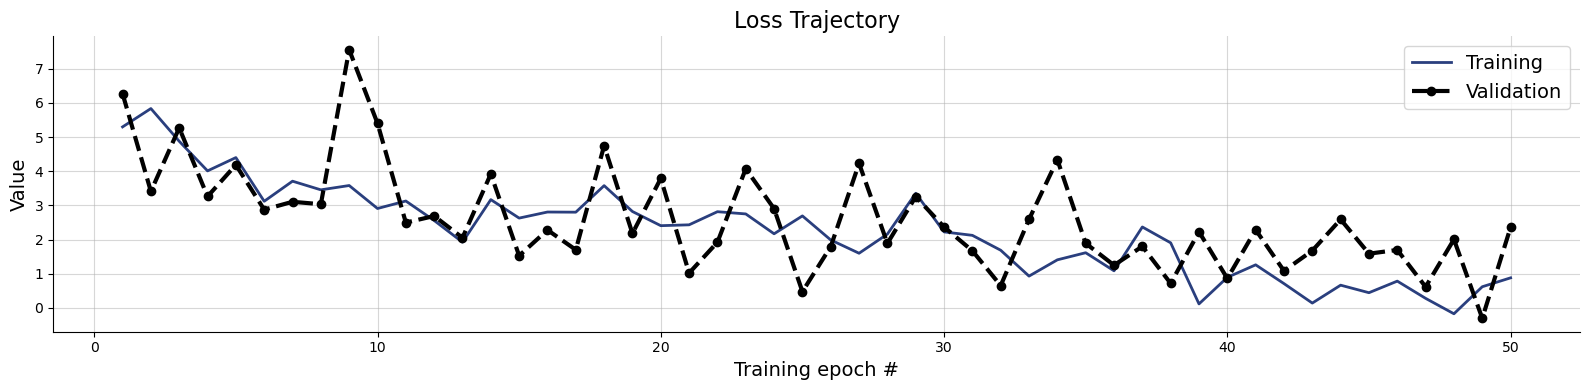

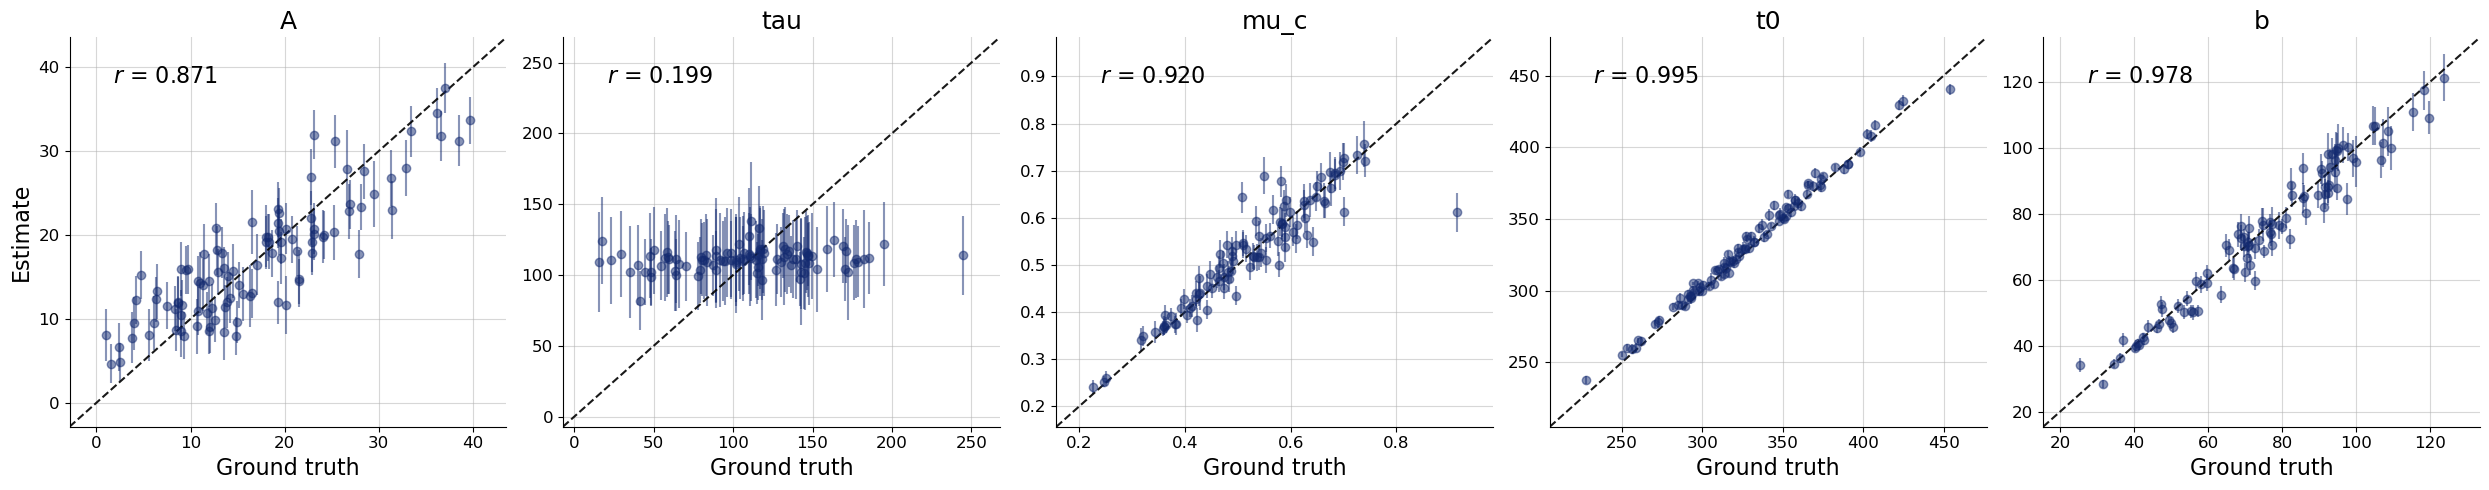

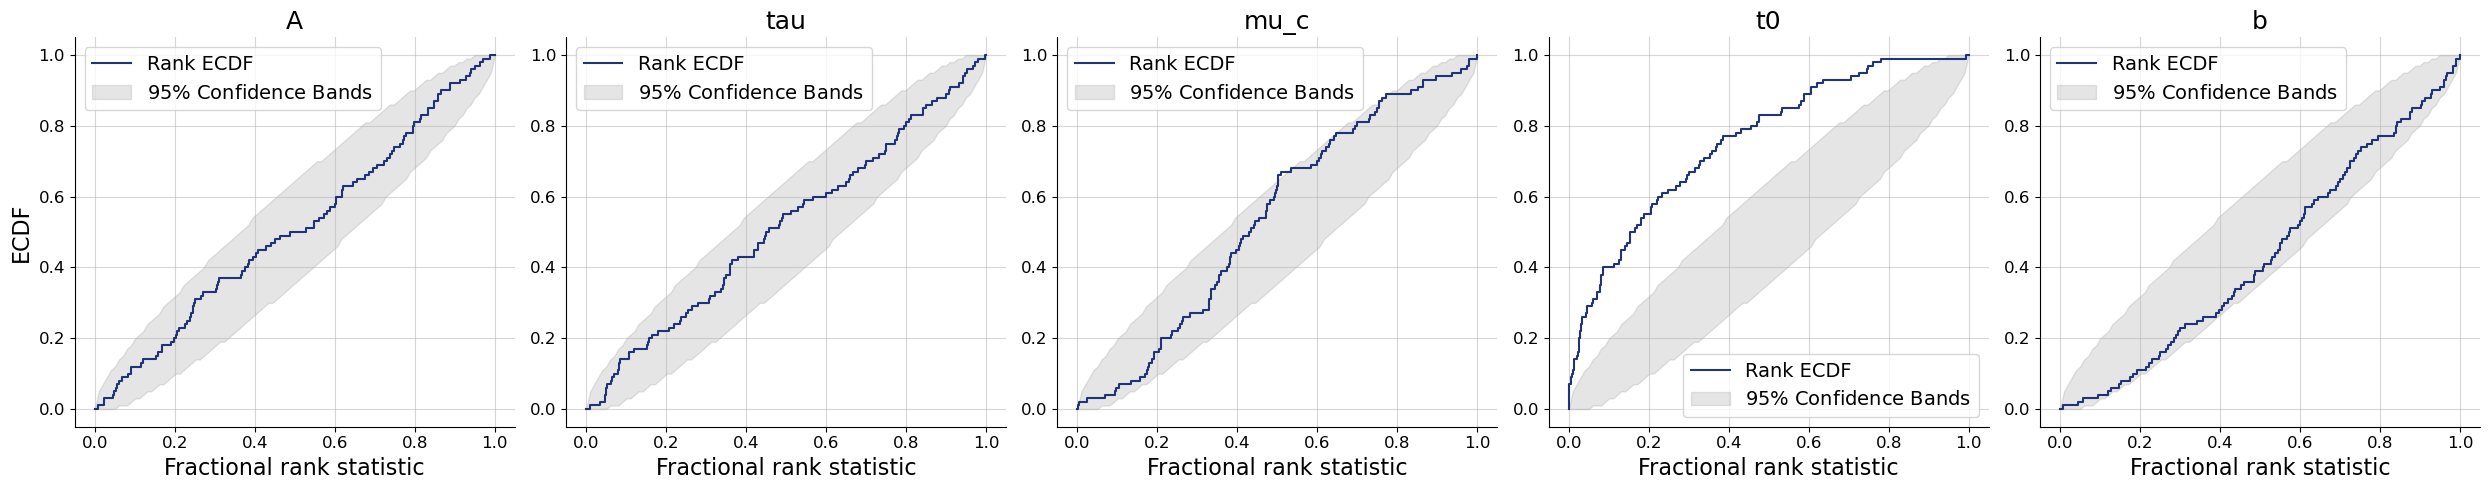

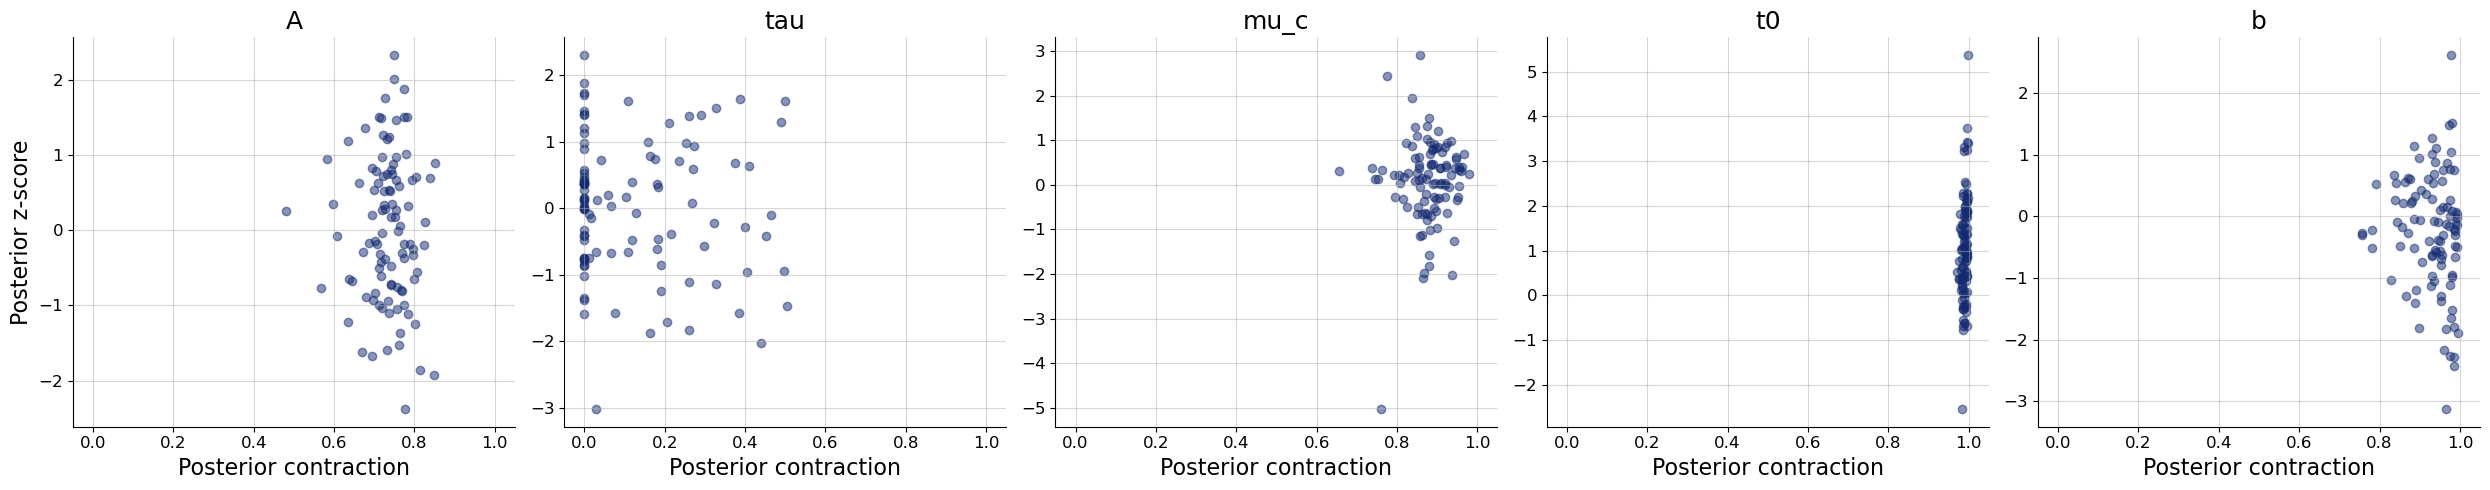

In [29]:
figs = workflow.plot_default_diagnostics(test_data=val_data)

In [30]:
table = workflow.compute_default_diagnostics(test_data=val_data)
table

,A,tau,mu_c,t0,b
NRMSE,0.164508,0.266803,0.092647,0.031504,0.076853
Posterior Contraction,0.737898,0.044117,0.883053,0.991366,0.943131
Calibration Error,0.020789,0.025000,0.072368,0.130000,0.022368


In [ ]:
table = workflow.compute_custom_diagnostics(test_data=val_data)

## Custom Stuff

In [34]:
approximator = keras.saving.load_model("checkpoints/test/simons_crazy_net.keras")

/home/radevs/anaconda3/envs/bayeskeras/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [37]:
samples = approximator.sample(conditions=val_data, num_samples=1000)

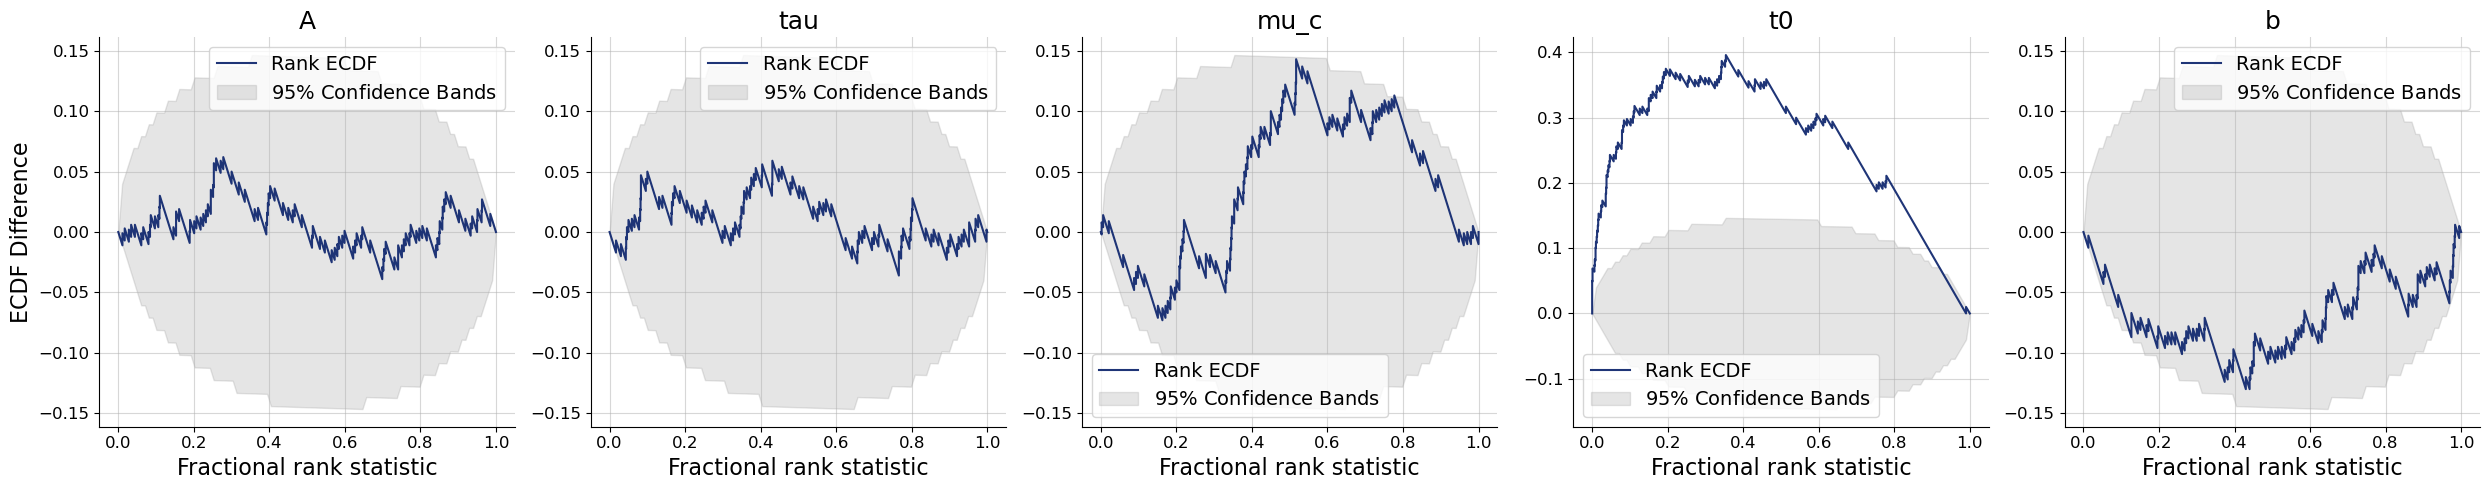

In [43]:
sbc = bf.diagnostics.plots.calibration_ecdf(samples, val_data, variable_keys=["A", "tau", "mu_c", "t0", "b"], difference=True)

## Real Data Inference

In [ ]:
#TODO

## Posterior Predictive Checks

In [ ]:
#TODO